In [1]:
import os, time, random, math, shutil, random
import csv
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Audio

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio.functional as F
import torchaudio.transforms as T

import librosa

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 2 to use

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# data

## dataload
- label이 있는 데이터를 불러오고, 그것들을 target으로 옮기기

In [5]:
label = pd.read_csv('data/label_list.csv')

In [37]:
import shutil
for i in range(len(names)):
    filename = str('data/origin_wav/' + names['filename'][i] + '.wav')
    copyname = str('data/seg_wav/' + names['filename'][i] + '.wav')
    shutil.copy(filename, copyname)

In [39]:
for i in range(len(names)):
    filename = str('data/wav/' + names['filename'][i] + '.wav')
    wav, sr = torchaudio.load(filename)
    print(sr)

48000
48000
48000
48000
48000
48000
48000
48000
44100
44100
44100
44100
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000
48000


## data summary

### 데이터 길이 확인

In [8]:
length = []
filename = str('hello')
for i in range(len(data)):
    if filename == data.filename[i]:
        pass
    else:
        filename = data.filename[i]
        waveform, sample_rate = torchaudio.load(os.path.join(param.data_path,filename)+'.wav')
        resize = torchaudio.transforms.Resample(sample_rate, param.sample_rate)(waveform)
        length.append(len(resize[0])/22050)

In [9]:
np.max(length)

27.360680272108844

In [10]:
data.end.max()

23.866

data의 최대 길이는 27.36초이나 wheezing이 존재하는 최대의 길이는 23.86이므로 25초까지만 패딩하자.

### 스테레오 여부 확인

In [11]:
for i in range(len(data)):
    if filename == data.filename[i]:
        pass
    else:
        filename = data.filename[i]
        waveform, sample_rate = torchaudio.load(os.path.join(param.data_path,filename)+'.wav')
        print(f'{filename}s channel : {waveform.shape[0]}')

0001-1s channel : 1
0001-3s channel : 1
0001-4s channel : 1
0020-1s channel : 1
0020-3s channel : 1
0020-4s channel : 1
0025-3s channel : 1
0025-4s channel : 1
0107-1s channel : 1
0107-2s channel : 1
0107-3s channel : 1
0107-4s channel : 1
0261-2s channel : 1
0261-3s channel : 1
0411-2s channel : 1
0411-3s channel : 1
0515-1s channel : 1
0526-3s channel : 1
0526-4s channel : 1
0533-1s channel : 1
0533-2s channel : 1
0534-4s channel : 1
0535-3s channel : 1
0538-1s channel : 1
0538-2s channel : 1
0538-3s channel : 1
0538-4s channel : 1
0539-3s channel : 1
0539-4s channel : 1
0549-2s channel : 1
0550-3s channel : 1
0550-4s channel : 1
0559-1s channel : 1
0559-2s channel : 1
0559-3s channel : 1
0559-4s channel : 1
0568-1s channel : 1
0568-2s channel : 1
0568-3s channel : 1
0568-4s channel : 1
0581-1s channel : 1
0581-2s channel : 1
0581-4s channel : 1
0588-2s channel : 1
0588-3s channel : 1
0590-1s channel : 1
0590-2s channel : 1
0590-3s channel : 1
0593-3s channel : 1
0593-4s channel : 1


In [12]:
from sklearn.model_selection import train_test_split, KFold

In [13]:
train_set, test_set = train_test_split(data,test_size=0.2, random_state=param.random_state)

In [14]:
print(f'train : {len(train_set)}, test : {len(test_set)}')

train : 151, test : 38


## audio preprocess

## 1채널로 만들기

In [1]:
from subprocess import Popen, PIPE

In [6]:
audio_files = glob.glob('data/labeled_wheezing/*.wav')

In [8]:
audio_files = glob.glob('data/non_wheezing/*.wav')

In [9]:
for sound in audio_files:
    temp_file = sound.replace("non_wheezing","mono_non_wheezing")
    command = "sox " + sound + " " + temp_file + " channels 1"
    p = Popen(command, stdin=PIPE, stdout=PIPE, stderr=PIPE, shell=True)
    output, err = p.communicate()

### non-wheezing label 만들기

In [30]:
non_wheezings = glob.glob('data/mono_non_wheezing/*.wav')

In [31]:
for _, path in enumerate(non_wheezings):
    with open(path.replace('.wav','.ann'), 'w') as fp:
        fp.write('0,0,non-wheezing')
    fp.close()

## label 분할

In [12]:
label = pd.read_csv('data/label_list.csv')
data = np.array(label)

In [27]:
def label_seperate(audio_path, data):
    now = data[0][0]
    lists = []
    count = 0
    for i in range(len(data)):
        if now == data[i][0]:
            lists.append(data[i])
        elif count != 0 : 
            label_name=f'{audio_path}/{data[i-1][0]}.ann'
            with open(label_name, 'w') as fp:
                fp.write('\n'.join('{},{},{}'.format(x[2], x[3], x[1]) for x in lists))
            lists = []
            now=data[i][0]
            lists.append(data[i])
        else :
            now=data[i][0]
            lists.append(data[i])
        count += 1
    label_name=f'{audio_path}/{data[i][0]}.ann'
    with open(label_name, 'w') as fp:
        fp.write('\n'.join('{},{},{}'.format(x[2], x[3], x[1]) for x in lists))

In [29]:
label_seperate('data/mono_wheezing',data=data)

## 레이블 만들기

In [10]:
wavs = glob.glob('data/mono_non_wheezing_wav/*.wav')

In [13]:
train_wav = wavs[:int(len(wavs)*0.9)]
val_wav = wavs[int(len(wavs)*0.9):]

In [347]:
read_annotation(wavs[0].replace('.wav','.ann'))

[['0.444', '0.656', 'wheezing'],
 ['0.832', '1.12', 'wheezing'],
 ['4.82', '5.781', 'wheezing'],
 ['6.868', '7.529', 'wheezing'],
 ['9.038', '9.306', 'wheezing']]

In [2]:
def construct_labels(annotation_path, win_start, win_end, win_len):
    events = read_annotation(annotation_path)
    #원래 3번째 값은 e[2]로 특정 클래스인데, 여긴 binary니깐 1로 변경
    ann = [[float(e[0]), float(e[1]), 1] for e in events]
    
    curr_ann = []
    
    for a in ann:
        if a[1] > win_start and a[0] <= win_end: 
        # if a[0] >= win_start and a[0] < win_end:
            curr_start = max(a[0] - win_start, 0.0)
            curr_end = min(a[1] - win_start, win_len)
            curr_ann.append([curr_start, curr_end, a[2]])    
    
    class_set = set([c[2] for c in curr_ann])
    class_wise_events = {}
    
    for c in list(class_set):
        class_wise_events[c] = []
        
    
    for c in curr_ann:
        class_wise_events[c[2]].append(c)
        
    max_event_silence = 0.0
    all_events = []
    
    for k in list(class_wise_events.keys()):
        curr_events = class_wise_events[k]
        count = 0
    
        while count < len(curr_events) - 1:
            if (curr_events[count][1] >= curr_events[count + 1][0]) or (curr_events[count + 1][0] - curr_events[count][1] <= max_event_silence):
                curr_events[count][1] = max(curr_events[count + 1][1], curr_events[count][1])
                del curr_events[count + 1]
            else:
                count += 1
        
        all_events += curr_events
    
    for i in range(len(all_events)):
        all_events[i][0] = round(all_events[i][0], 3)/0.3
        all_events[i][1] = round(all_events[i][1], 3)/0.3
    
    all_events.sort(key=lambda x: x[0])
    if all_events==[]:
        all_events=[[0, 0, 0]]
  
    return all_events

In [3]:
def read_annotation(filename):
    events = []
    with open(filename, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            events.append(row)
    return events

## 멜스펙트로그램 그려보기

In [68]:
wav, sr = torchaudio.load('data/mono_wav/0261-2.wav')

In [69]:
wav = T.Resample(sr, 44100)(wav)[0]

In [210]:
seg_wav = wav[int(44100*0.3)*2:int(44100*0.3)*3]

In [187]:
seg_wav = wav[int(44100)*0:int(44100)*3]

In [71]:
len(seg_wav)

13230

In [25]:
import librosa

In [141]:
librosa.feature.melspectrogram

<function librosa.feature.spectral.melspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512, win_length=None, window='hann', center=True, pad_mode='reflect', power=2.0, **kwargs)>

In [143]:
seg_wav

tensor([0.0069, 0.0074, 0.0073,  ..., 0.0122, 0.0124, 0.0126])

In [118]:
librosa.feature.melspectrogram?

Signature:
librosa.feature.melspectrogram(
    y=None,
    sr=22050,
    S=None,
    n_fft=2048,
    hop_length=512,
    win_length=None,
    window='hann',
    center=True,
    pad_mode='reflect',
    power=2.0,
    **kwargs,
)
Docstring:
Compute a mel-scaled spectrogram.

If a spectrogram input ``S`` is provided, then it is mapped directly onto
the mel basis by ``mel_f.dot(S)``.

If a time-series input ``y, sr`` is provided, then its magnitude spectrogram
``S`` is first computed, and then mapped onto the mel scale by
``mel_f.dot(S**power)``.

By default, ``power=2`` operates on a power spectrum.

Parameters
----------
y : np.ndarray [shape=(n,)] or None
    audio time-series

sr : number > 0 [scalar]
    sampling rate of ``y``

S : np.ndarray [shape=(d, t)]
    spectrogram

n_fft : int > 0 [scalar]
    length of the FFT window

hop_length : int > 0 [scalar]
    number of samples between successive frames.
    See `librosa.stft`

win_length : int <= n_fft [scalar]
    Each frame of au

In [119]:
T.MelSpectrogram?

Init signature:
T.MelSpectrogram(
    sample_rate: int = 16000,
    n_fft: int = 400,
    win_length: Union[int, NoneType] = None,
    hop_length: Union[int, NoneType] = None,
    f_min: float = 0.0,
    f_max: Union[float, NoneType] = None,
    pad: int = 0,
    n_mels: int = 128,
    window_fn: Callable[..., torch.Tensor] = <built-in method hann_window of type object at 0x7f7e55fd1ce0>,
    power: Union[float, NoneType] = 2.0,
    normalized: bool = False,
    wkwargs: Union[dict, NoneType] = None,
    center: bool = True,
    pad_mode: str = 'reflect',
    onesided: bool = True,
    norm: Union[str, NoneType] = None,
) -> None
Docstring:     
Create MelSpectrogram for a raw audio signal. This is a composition of Spectrogram
and MelScale.

Sources
    * https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
    * https://timsainb.github.io/spectrograms-mfccs-and-inversion-in-python.html
    * http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

Args:
    

In [ ]:
sr = 44100, hop_length = 441, win_length = 1764, n_fft = 2048, n_mels = 40, fmin = 0, fmax = 22050

(60, 414)


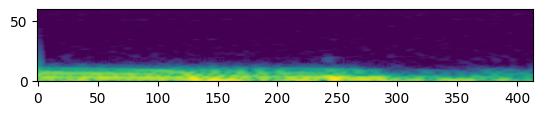

In [233]:
bands = librosa.feature.melspectrogram(y=np.array(seg_wav), sr=44100, hop_length=32, win_length = 511, n_fft=1024, n_mels=60, dtype=np.float32)
bands = librosa.core.power_to_db(bands)
print(bands.shape)
plt.imshow(bands, origin='lower')

torch.Size([60, 31])


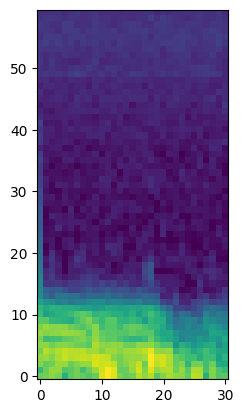

In [221]:
mel = T.MelSpectrogram(sample_rate=44100, hop_length=441, win_length=882, n_fft = 2048, n_mels = 60)(seg_wav)
mel = T.AmplitudeToDB(top_db=80)(mel)
print(mel.shape)
plt.imshow(mel, origin='lower')

## 오디오 분할

In [22]:
params={
    "wav_len" : 0.3,
    "wav_hop" : 0.2,
    "sr" : 44100,
    "n_fft" : 2048,
    "mel_win" : 882,
    "mel_hop" : 441, #torchaudio default로써 hop_length=nfft//2
    "n_mels" : 31,
    "top_db" : 80 #torchaudio가 80이 합리적이라고 함. 근데 보니깐 이게 호흡음이고, 작은 소리였다보니 80은 불필요한 수준일수도
}

In [5]:
wheezing_wavs = glob.glob('data/mono_wheezing/*.wav')

In [23]:
save_folder = 'data/sep_wav/w2h1m31'
try : 
    #os.mkdir(f'data/sep_wav')
    os.mkdir(f'{save_folder}')
    os.mkdir(f'{save_folder}/non_wheezing')
    os.mkdir(f'{save_folder}/wheezing')
except:
    print('already exist')

In [24]:
#spectrogram과 레이블을 0.3초 단위로 다 자르기
for num, data in enumerate(wheezing_wavs):
    wav, sr = librosa.load(data)
    wav = librosa.resample(wav, orig_sr=sr, target_sr=params['sr'])
    mels = []
    labels = []
    
    interval_nums = int(np.ceil(len(wav)/params['sr']/params['wav_hop']))
    for i in range(interval_nums):
        # make part of wav
        start_time = i*int(params['sr']*params['wav_hop'])
        end_time = i*int(params['sr']*params['wav_hop'])+int(params['sr']*params['wav_len'])    
        new_wav = wav[start_time:end_time]

        # zero-padding
        if new_wav.shape[0] < params['sr']*params['wav_len']:
            zeros = np.zeros(int(params['sr']*params['wav_len']) - len(new_wav))
            new_wav = np.concatenate([new_wav, zeros])

        # make melspectrogram
        if sum(np.abs(new_wav))==0:
            print('pass') # there is no information don't need this wav
        else : 
            mel = librosa.feature.melspectrogram(y=np.array(new_wav), sr=params['sr'], hop_length=params['mel_hop'], win_length = params['mel_win'], n_fft=params['n_fft'], n_mels=params['n_mels'], dtype=np.float32)
            mel = librosa.core.power_to_db(mel)
        
            label = construct_labels(data.replace('.wav','.ann'), win_start = i*params['wav_hop'], win_end = i*params['wav_hop'] + params['wav_len'], win_len = params['wav_len'])

            #classification of wheezing
            if sum(label[0])==0:
                interval_name = data[:-4].replace('data/mono_wheezing',f'{save_folder}/non_wheezing')+f'_{i}'
            else:
                interval_name = data[:-4].replace('data/mono_wheezing',f'{save_folder}/wheezing')+f'_{i}'

            #save
            np.save(f'{interval_name}.npy', mel)
            with open(f'{interval_name}.ann', 'w') as fp:
                fp.write('\n'.join('{},{},{}'.format(x[0], x[1], x[2]) for x in label))

pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass


In [8]:
non_wheezing_wavs = glob.glob('data/mono_non_wheezing/*.wav')

In [25]:
#spectrogram과 레이블을 0.3초 단위로 다 자르기
for num, data in enumerate(non_wheezing_wavs):
    wav, sr = librosa.load(data)
    wav = librosa.resample(wav, orig_sr=sr, target_sr=params['sr'])
    mels = []
    labels = []
    
    interval_nums = int(np.ceil(len(wav)/params['sr']/params['wav_hop']))
    for i in range(interval_nums):
        # make part of wav
        interval_name = data[:-4].replace('data/mono_non_wheezing',f'{save_folder}/non_wheezing')+f'_{i}'
        start_time = i*int(params['sr']*params['wav_hop'])
        end_time = i*int(params['sr']*params['wav_hop'])+int(params['sr']*params['wav_len'])    
        new_wav = wav[start_time:end_time]

        # zero-padding
        if new_wav.shape[0] < params['sr']*params['wav_len']:
            zeros = np.zeros(int(params['sr']*params['wav_len']) - len(new_wav))
            new_wav = np.concatenate([new_wav, zeros])

        # make mel
        if sum(np.abs(new_wav))==0:
            print('pass') # there is no information don't need this wav
        else : 
            mel = librosa.feature.melspectrogram(y=np.array(new_wav), sr=params['sr'], hop_length=params['mel_hop'], win_length = params['mel_win'], n_fft=params['n_fft'], n_mels=params['n_mels'], dtype=np.float32)
            mel = librosa.core.power_to_db(mel)
            np.save(f'{interval_name}.npy', mel)

            # save
            label = construct_labels(data.replace('.wav','.ann'), win_start = i*params['wav_hop'], win_end = i*params['wav_hop']+params['wav_len'], win_len = params['wav_len'])
            with open(f'{interval_name}.ann', 'w') as fp:
                fp.write('\n'.join('{},{},{}'.format(x[0], x[1], x[2]) for x in label))

## dataset

In [8]:
# sample rate 22050, n_mels=64, n_fft=int(0.2625*args.length)
# sr 16000, hop_length=160, win_length=400, n_fft=512, n_mels=64, f_min=125, f_max=7500

In [ ]:
wheezings = glob.glob('data/sep_wav/w2h1m6/wheezing/*.ann')
non_wheezings = glob.glob('data/sep_wav/w2h1m6/non_wheezing/*.ann')

In [ ]:
class Breath_Dataset(torch.utils.data.Dataset):
    def __init__(self, wheezing, non_wheezing, ratio=1):
        self.wheezings = wheezing
        self.non_wheezing = non_wheezing
        self.ratio = ratio
        self.data = random.shuffle(wheezing+non_wheezing)
        
    def __len__(self):
        return len(self.data)

    def downsampling(self, seed=None):
        if seed != None:
            random.seed(seed)
        self.non_wheezing = random.shuffle(self.non_wheezing)
        self.data = random.shuffle(wheezing+non_wheezing[:len(wheezing)*ratio])
    
    def __getitem__(self, index):
        # process : load -> resampling -> padding -> mel_spectro_gram -> spec_augment
        mel = np.load(self.data[index])
        ann = read_annotation(self.data[index].replace('.npy','.ann'))[0]
        
        return mel, ann[2]

In [ ]:
DS = Breath_Dataset(wheezings, non_wheezings, ratio=1)

In [ ]:
train_dataset, val_dataset, _ = random_split(DS, [0.8, 0.2, 0.0])

In [7]:
train_loader = DataLoader(train_dataset, batch_size = 32, num_workers = 0, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, num_workers = 0, shuffle = False)

## datasplit

# loss function and optimizer

In [8]:
import torch.nn as nn

In [9]:
loss_fn = nn.BCELoss()

# model

In [59]:
class toymodel(nn.Module):
    def __init__(self):
        super(toymodel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.ffn = nn.Linear(128,1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(dim=1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn16(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn32(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn64(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.bn128(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.ffn(x)
        x = self.sig(x)

        return x

In [ ]:
class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.2,
    ) -> None:
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use
            dropout (float): The droupout probability

        """
        super().__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1024

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError(
                f"inverted_residual_setting should be non-empty or a 4-element list, got {inverted_residual_setting}"
            )

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [
            Conv2dNormActivation(3, input_channel, stride=2, norm_layer=norm_layer, activation_layer=nn.ReLU6)
        ]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(
            Conv2dNormActivation(
                input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6
            )
        )
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


_COMMON_META = {
    "num_params": 3504872,
    "min_size": (1, 1),
    "categories": _IMAGENET_CATEGORIES,
}

In [37]:
class DSBlock(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super(DSBlock, self).__init__()
        self.depth_conv = nn.Conv2d(in_c, in_c, kernel_size=3, stride=stride, padding='valid', groups=in_c, bias=False)
        self.bn1 = nn.BatchNorm2d(in_c)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding='valid', bias=False)
        self.bn2 = nn.BatchNorm2d(out_c)
    def forward(self, x):
        x = self.depth_conv(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [61]:
LAYER_DEFS = [
    (32, 64, 1),
    (64, 128, 1),
    (128, 128, 1),
    (128, 256, 1),
    (256, 256, 1),
    #(256, 512, 2),
    #(512, 512, 1),
    #(512, 512, 1),
    #(512, 512, 1),
    #(512, 512, 1),
    #(512, 512, 1),
    #(512, 1024, 2),
    #(1024, 1024, 1),
    #(1024, 512, 1),
    #(512, 256, 1),
    (256, 128, 1)
]

In [62]:
class YOHO(nn.Module):
    def __init__(self, layer_def):
        super(YOHO, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding='valid')
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(32)
        self.layer_def = layer_def
        features: List[nn.Module] = []
        for i in range(len(layer_def)):
            features.append(DSBlock(layer_def[i][0], layer_def[i][1], layer_def[i][2]))
        self.features = nn.Sequential(*features)
        self.last = nn.Conv1d(256, 3, kernel_size=1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.features(x)
        x = x.view(-1, -1, 256)
        x = self.last(x)
        output = self.activation(x)
        return output

In [63]:
model = YOHO(LAYER_DEFS)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

YOHO(
  (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  (relu): ReLU()
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (features): Sequential(
    (0): DSBlock(
      (depth_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid, groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=valid, bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DSBlock(
      (depth_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid, groups=64, bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=valid, bias=False)
      (bn2): BatchNorm2d(12

In [74]:
for i, batch in enumerate(train_loader):
    if i==0:break
batch = batch[0].cuda()
batch.shape

torch.Size([32, 60, 30])

In [72]:
model(batch)

RuntimeError: only one dimension can be inferred

In [64]:
x=model.conv(batch.unsqueeze(1))
x.shape

torch.Size([32, 32, 29, 14])

In [73]:
x1=model.features(x)
x1.shape

torch.Size([32, 128, 17, 2])

In [115]:
x2 = x1.view(32, -1, 2)
x2.shape

torch.Size([32, 2176, 2])

In [116]:
out = nn.Conv1d(2176, 3, kernel_size=1).cuda()(x2)
out.shape

torch.Size([32, 3, 2])

In [117]:
output = nn.Sigmoid().cuda()(out)
output.shape

torch.Size([32, 3, 2])

In [118]:
output

tensor([[[0.5933, 0.5529],
         [0.4039, 0.5955],
         [0.5586, 0.6596]],

        [[0.5033, 0.4792],
         [0.4792, 0.5191],
         [0.6065, 0.6582]],

        [[0.4444, 0.4764],
         [0.5526, 0.5304],
         [0.5597, 0.5079]],

        [[0.5301, 0.4614],
         [0.5072, 0.4744],
         [0.5357, 0.4816]],

        [[0.4207, 0.5815],
         [0.4081, 0.4473],
         [0.5410, 0.6022]],

        [[0.3436, 0.5761],
         [0.4861, 0.5358],
         [0.5052, 0.7414]],

        [[0.3420, 0.4438],
         [0.4590, 0.5760],
         [0.3561, 0.6474]],

        [[0.7832, 0.6845],
         [0.6299, 0.6179],
         [0.6644, 0.6292]],

        [[0.4445, 0.5055],
         [0.5332, 0.6430],
         [0.6368, 0.5395]],

        [[0.3694, 0.5984],
         [0.4150, 0.4942],
         [0.6198, 0.5887]],

        [[0.4591, 0.4893],
         [0.5636, 0.4845],
         [0.5446, 0.6146]],

        [[0.4372, 0.4983],
         [0.3937, 0.5713],
         [0.5700, 0.5525]],

    

In [62]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
best_val_loss = 1e+10
for epoch in range(100):
    train_loss = 0
    for i, batch in enumerate(train_loader):
        model.train()
        mel, label = batch[0].to(device), torch.tensor(np.array(batch[1], dtype=np.float32)).to(device)
        output = model(mel)
        output = output.squeeze(1)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss
    
    val_loss = 0
    preds = torch.tensor([])
    labels = torch.tensor([])
    for i, batch in enumerate(val_loader):
        model.eval()
        mel, label = batch[0].to(device), torch.tensor(np.array(batch[1], dtype=np.float32))
        output = model(mel)
        output = output.squeeze(1)
        loss = loss_fn(output, label.cuda())
        val_loss += loss
        pred = output>0.5
        preds = torch.cat([preds,pred.cpu()])
        labels = torch.cat([labels,label.cpu()])
    tn, fp, fn, tp = confusion_matrix(preds, labels).ravel()
    print(f'epoch{epoch} train_loss {train_loss:.4f}, val_loss {val_loss:.4f}, confusion_mat {tp, fp, fn, tn}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'best_model.pt')
        print('above is best cp')

epoch0 train_loss 38.7001, val_loss 9.0036, confusion_mat (60, 33, 68, 308)
above is best cp
epoch1 train_loss 37.2993, val_loss 8.9900, confusion_mat (59, 34, 75, 301)
above is best cp
epoch2 train_loss 35.8501, val_loss 8.6476, confusion_mat (56, 37, 69, 307)
above is best cp
epoch3 train_loss 34.3338, val_loss 10.2527, confusion_mat (65, 28, 163, 213)
epoch4 train_loss 33.1499, val_loss 8.0592, confusion_mat (54, 39, 63, 313)
above is best cp
epoch5 train_loss 31.7960, val_loss 7.7793, confusion_mat (30, 63, 37, 339)
above is best cp
epoch6 train_loss 30.2871, val_loss 7.4804, confusion_mat (37, 56, 38, 338)
above is best cp
epoch7 train_loss 28.5562, val_loss 6.7335, confusion_mat (32, 61, 28, 348)
above is best cp
epoch8 train_loss 26.7849, val_loss 6.9976, confusion_mat (11, 82, 6, 370)
epoch9 train_loss 25.7720, val_loss 6.7557, confusion_mat (24, 69, 15, 361)
epoch10 train_loss 24.2025, val_loss 6.3354, confusion_mat (28, 65, 23, 353)
above is best cp
epoch11 train_loss 24.0816

In [121]:
val_loss = 0
preds = torch.tensor([])
labels = torch.tensor([])
for i, batch in enumerate(val_loader):
    model.eval()
    mel, label = batch[0].to(device), torch.tensor(np.array(batch[1], dtype=np.float32))
    output = model(mel)
    output = output.squeeze(1)
    loss = loss_fn(output, label.cuda())
    val_loss += loss
    pred = output>0.5
    preds = torch.cat([preds,pred.cpu()])
    labels = torch.cat([labels,label.cpu()])

In [124]:
tn, fp, fn, tp = confusion_matrix(preds, labels).ravel()

In [125]:
print(tp, fn, fp, tn)

0 0 43 192


tensor([0., 0.])

In [122]:
confusion_matrix(preds, labels)

array([[192,  43],
       [  0,   0]])